<h1>Data input</h1>

Begin by importing the help functions in the 'proto' package:

In [1]:
import fit_functions

Define data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be ignored by fit: simple 2-column ASCII file
 - model to be fitted: ASCII file in specfit's IRAF database format.

In [2]:
datafile = "../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../data/n5548/n5548_lyalpha_sample.dat"
modelfile = "../data/n5548/sfn5548_lyalpha_all_first.dat"

Read spectrum and regions files. 

Spectrum is returned as an object that encapsulates wavelength, flux, and error arrays. 

Mask is a float numpy array with 1's for good data points and 0's for ignored data points.

In [3]:
spectrum, mask = fit_functions.read_file(datafile, regions=regionsfile)

Read model:

In [4]:
model = fit_functions.read_model(modelfile)

Model is a list of functions defined in astropy.modeling.models. 

In [5]:
print(model)

[<powerlaw(amplitude=6.5862e-14, x_0=1000.0, alpha=0.4819233)>, <gaussian(norm=2e-14, mean=1195.006, fwhm=861.4926, skew=1.0)>, <gaussian(norm=1.438015e-14, mean=1226.392, fwhm=861.4926, skew=1.0)>, <gaussian(norm=2.02e-13, mean=1236.729, fwhm=255.4998, skew=1.0)>, <gaussian(norm=5.474183e-13, mean=1235.996, fwhm=861.4926, skew=1.0)>, <gaussian(norm=3.948799e-12, mean=1235.138, fwhm=3040.59, skew=1.0)>, <gaussian(norm=2.156964e-12, mean=1231.589, fwhm=8133.099, skew=1.0)>, <gaussian(norm=5.36853e-13, mean=1237.643, fwhm=18183.71, skew=1.0)>, <gaussian(norm=1.217935e-14, mean=1259.753, fwhm=255.4998, skew=1.0)>, <gaussian(norm=1.217935e-14, mean=1263.803, fwhm=255.4998, skew=1.0)>, <gaussian(norm=6.219548e-15, mean=1259.533, fwhm=861.4926, skew=1.0)>, <gaussian(norm=6.219548e-15, mean=1263.582, fwhm=861.4926, skew=1.0)>, <gaussian(norm=2.21692e-14, mean=1258.659, fwhm=3040.59, skew=1.0)>, <gaussian(norm=2.221692e-13, mean=1262.705, fwhm=3040.59, skew=1.0)>, <gaussian(norm=3.185217e-13, 

<h1>Fitting</h1>

So far, we have worked on having the data ingested into appropriate formats acceptable by the astropy fitting stuff.

Now, to fit the multiple components in the model simultaneously, we have to build a compound model. An astropy compound model is just a combination of all the functions in the model, using as combination operators such things as additin, multiplication, and others.

Example: 

<code>compound_model = models.PowerLaw1D(1.,1.) + models.Gaussian1D(1.,1.,1.)</code>

will create an instance of a compound model with two components.

We build our component model by calling a function in the fit_functions module that will just add together all the functions in the input list:

In [6]:
compound_model = fit_functions.compoundModel(model)

In [7]:
print(compound_model)

Model: CompoundModel19
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude_0 x_0_0   alpha_0  norm_1 ... mean_20  fwhm_20   skew_20 
    ----------- ------ --------- ------ ... -------- -------- ---------
     6.5862e-14 1000.0 0.4819233  2e-14 ... 1262.044 3683.102 0.1849483





The actual fitting then is a very simple operation. 

First, we instantiate a fitter engine:

In [8]:
import astropy.modeling.fitting as fitting

In [9]:
fitter = fitting.LevMarLSQFitter()

In this example, we have errors for the data points, so we can use their inverse as weights for the fit:

In [10]:
w = mask / spectrum.e.data

And rhe fit itself is made by just calling the fitter instance with the data, weights, and some control parameters if needed:

In [11]:
fit_result = fitter(compound_model, spectrum.x.data, spectrum.y.data, weights=w, acc=1.E-7, maxiter=1000)

In [12]:
print(fitter.fit_info['message'])

Number of calls to function has reached maxfev = 1000.


The result is another instance of a compound model, with the fitted values set into the  parameter values:

In [13]:
print(fit_result)

Model: CompoundModel19
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
       amplitude_0    x_0_0     alpha_0    ...    fwhm_20       skew_20    
    ----------------- ------ ------------- ... ------------- --------------
    9.04889323179e-14 1000.0 5.72394983998 ... 191.438187663 0.213355424647


In [14]:
import numpy as np
fix = np.asarray(fit_result.fixed.values())
n_free_par = sum(np.where(fix, 0, 1))
chisq_in = fit_functions.chisq(spectrum.x.data, spectrum.y.data, spectrum.e.data, mask, compound_model, n_free_par)
chisq_out = fit_functions.chisq(spectrum.x.data, spectrum.y.data, spectrum.e.data, mask, fit_result, n_free_par)
print("chisq from input model:  %f" % chisq_in)
print("chisq from output model: %f" % chisq_out)
print("Total data points: %d" % len(spectrum.x.data))
print("Data points in wavelength ranges: %d" % np.sum(mask))
print("Number of free parameters: %d" % n_free_par)
print("Number of iterations: %d" % fitter.fit_info['nfev'])


chisq from input model:  26.335699
chisq from output model: 6.735374
Total data points: 6058
Data points in wavelength ranges: 2318
Number of free parameters: 40
Number of iterations: 1036


<h1>Plots</h1>

In [15]:
import matplotlib.pyplot as plt

In [16]:
%matplotlib inline

<h3>Input spectrum and mask</h3>

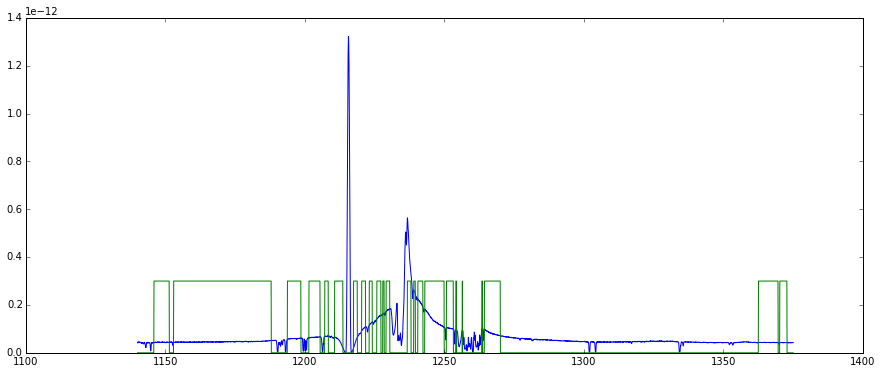

In [17]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, mask*3.E-13, 'g')

<h3>Compound model used as starting guess for fit</h3>

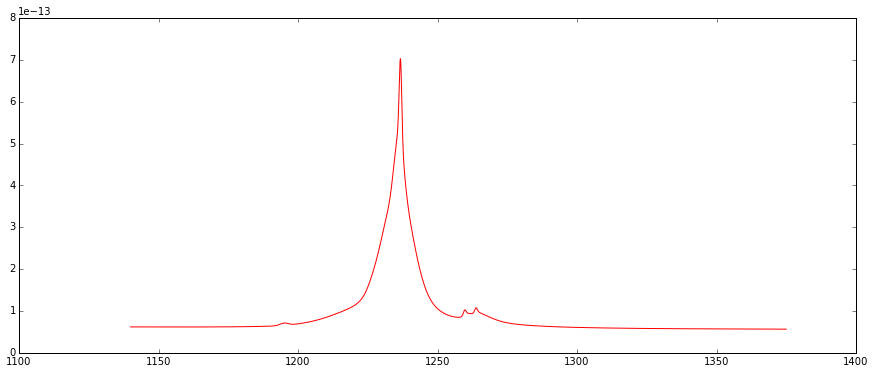

In [18]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, compound_model(spectrum.x.data), 'r')

<h3>Compound model produced by fit</h3>

In [19]:
fitted_spectrum = fit_result(spectrum.x.data)

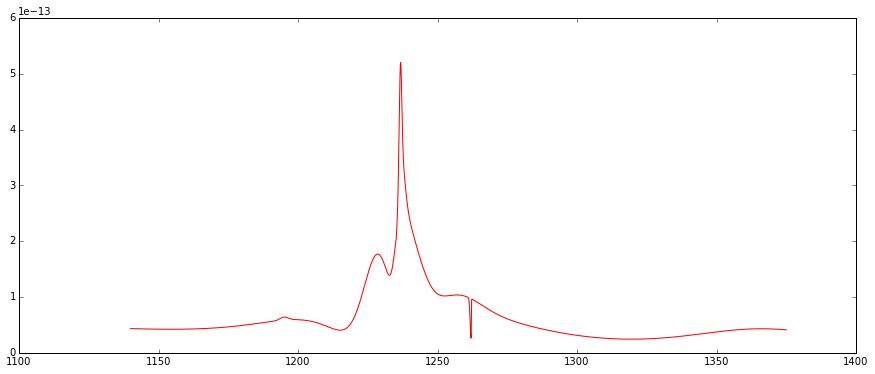

In [20]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.x.data, fitted_spectrum, 'r')

<h3>Starting guess compound model overploted on input spectrum</h3>

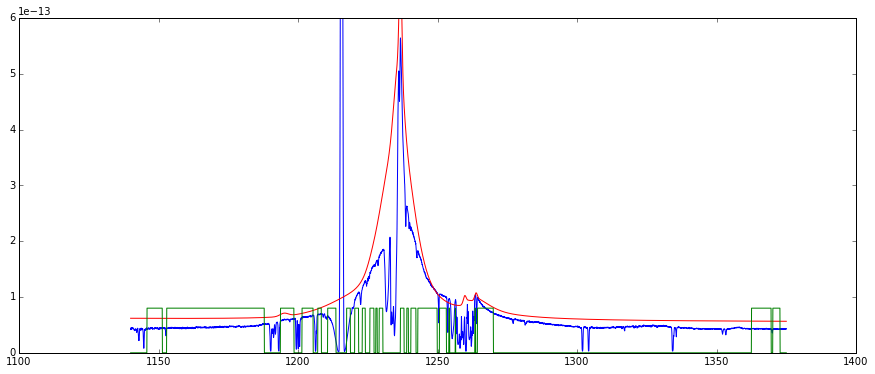

In [21]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, compound_model(spectrum.x.data), 'r')
plt.plot(spectrum.x.data, mask*8.E-14, 'g')

<h3>Fit result overploted on input spectrum</h3>

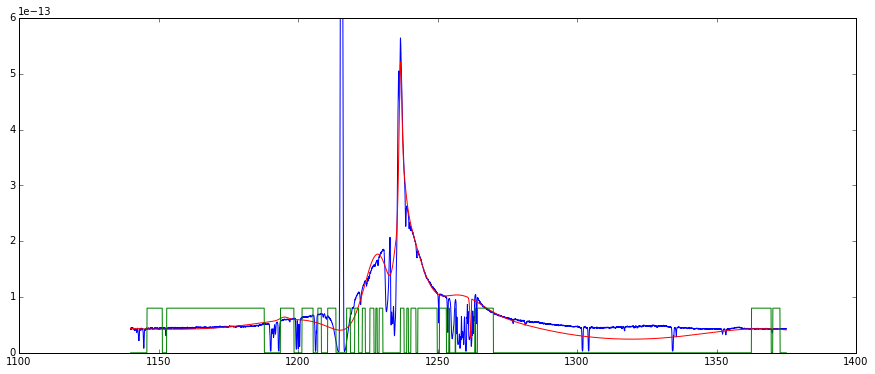

In [22]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')
plt.plot(spectrum.x.data, fitted_spectrum, 'r')
plt.plot(spectrum.x.data, mask*8.E-14, 'g')

<h3>Residuals</h3>

input spectrum - input model: plotted in yellow

input spectrum - fitted model: plotted in blue

In [23]:
residuals = spectrum.y.data - fitted_spectrum
original_residuals = spectrum.y.data - compound_model(spectrum.x.data)

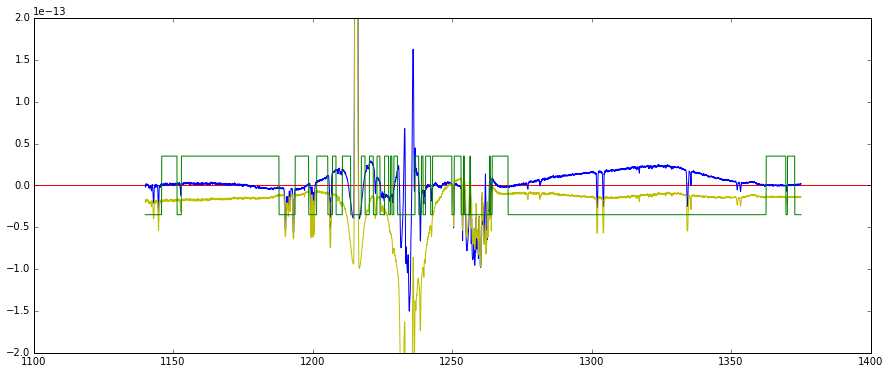

In [24]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(-2.e-13, 2.e-13)
plt.plot([1100., 1400], [0., 0.], 'r')
plt.plot(spectrum.x.data, residuals, 'b')
plt.plot(spectrum.x.data, original_residuals, 'y')
plt.plot(spectrum.x.data, (mask-0.5)*7.E-14, 'g')

<h3>Detail of residuals plot</h3>

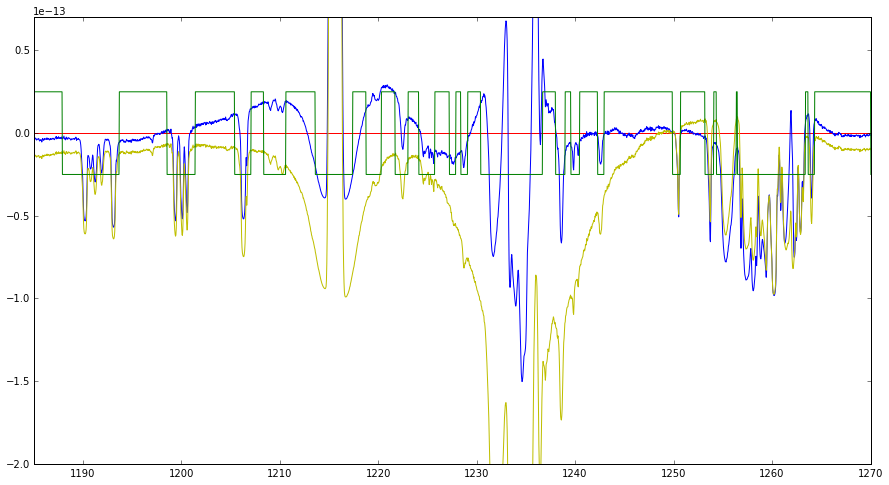

In [25]:
plt.gcf().set_size_inches(15.,8.)
plt.xlim(1185., 1270.)
plt.ylim(-2.e-13, 0.7e-13)
plt.plot([1185., 1270], [0., 0.], 'r')
plt.plot(spectrum.x.data, residuals, 'b')
plt.plot(spectrum.x.data, original_residuals, 'y')
plt.plot(spectrum.x.data, (mask-0.5)*5.E-14, 'g')